In [1]:
%matplotlib notebook
import pydiablo as d2
from pydiablo.d2data import D2Data
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
"""
class TreasureClassEx(D2Data):
    @staticmethod
    def filling_values():
        fv = {}
        difficulties = ('', 'N', 'H')
        for difficulty in difficulties:
            item_cols = ['Item{}'.format(x) for x in range(1,11)]
            prob_cols = ['Prob{}'.format(x) for x in range(1,11)] + ['NoDrop']
            mod_cols = ['Unique', 'Set', 'Rare', 'Magic']
            for col in item_cols:
                fv[col] = ''
            for col in prob_cols+mod_cols:
                fv[col] = 0
        return fv
    
    def __init__(self, filename):
        D2Data.__init__(self, filename, 'Treasure_Class')
"""
        
class Items(D2Data):
    def __init__(self, filename):
        D2Data.__init__(self, filename, 'code')
    
class ItemTypes(D2Data):
    def __init__(self, filename):
        D2Data.__init__(self, filename, 'Code')

In [5]:
tcex = d2.monster.TreasureClassEx('data/global/excel/TreasureClassEx.txt')
weapons = Items('data/global/excel/weapons.txt')
armors = Items('data/global/excel/armor.txt')
miscs = Items('data/global/excel/misc.txt')
itemtypes = ItemTypes('data/global/excel/ItemTypes.txt')

In [6]:
MonsterType = d2.monster.Monster.create_monster_type('cr_archer3', d2.monster.HELL)
print(MonsterType.mlvl, MonsterType.mlvl_specific_area_names(), MonsterType.treasure_class())
print(MonsterType.is_boss())

85 ['Pit Level 1', 'Pit Level 2'] Act 5 (H) Miss C
False


In [7]:
g = nx.DiGraph()
i=0
for tc in tcex.data['Treasure_Class']:
    if tc:
        picks = tcex.get_data(tc, 'Picks')
        unique = tcex.get_data(tc, 'Unique')
        set_ = tcex.get_data(tc, 'Set')
        rare = tcex.get_data(tc, 'Rare')
        magic = tcex.get_data(tc, 'Magic')
        g.add_node(tc, picks=picks, unique=unique, set_=set_, rare=rare, magic=magic, name=tc)
for probs, items in zip(['Prob{}'.format(x) for x in range(1,11)], ['Item{}'.format(x) for x in range(1,11)]):
    for tc, prob, item in zip(tcex.data['Treasure_Class'], tcex.data[probs], tcex.data[items]):
        if tc and item:
            weight = 0
            if g.has_edge(tc, item):
                # if the edge is already present, we need to add to the existing weight
                weight = g[tc][item]['weight']
            # if graph doesn't have the node, it means the referenced 'item' is not in the TC column. It's either
            # an item or an atomic treasure class
            if not g.has_node(item):
                g.add_node(item, picks=1, unique=0, set_=0, rare=0, magic=0, name=item) # can override name later
            g.add_edge(tc, item, weight=prob+weight)
            if tc == '' or item == '' or item == False:
                print('tc: {} item: {}'.format(tc, item))
    g.add_node('NoDrop', picks=1, unique=0, set_=0, rare=0, magic=0, name='NoDrop')
    for tc, nodrop in zip(tcex.data['Treasure_Class'], tcex.data['NoDrop']):
        if tc and nodrop != 0:
            #g.add_edge(tc, 'NoDrop', weight=nodrop)
            if tc=='':
                print('qwer')
print(nx.dfs_predecessors(g, 'weap87'))
print(g.has_node('weap87'))

{}
True


In [8]:
from functools import reduce

g2 = nx.DiGraph() # graph for modeling hierarchy of atomic TCs
for wtype,equiv1,equiv2 in zip(itemtypes.data['Code'],itemtypes.data['Equiv1'],itemtypes.data['Equiv2']):
    if wtype:
        g2.add_node(wtype)
        if equiv1:
            #print(equiv1, wtype)
            g2.add_edge(equiv1, wtype)
        if equiv2:
            g2.add_edge(equiv2, wtype)

#for x in nx.edge_dfs(g2, source='axe', orientation='reverse'):
#    print(x)
#print(list(nx.dfs_preorder_nodes(g2, source='swor')))

for items in [weapons, armors, miscs]:
    for item in items.data['code']:
        if not item: continue
        itype = items.get_data(item, 'type')
        rarity = itemtypes.get_data(itype, 'Rarity')
        qlvl = items.get_data(item, 'level')
        name = items.get_data(item, 'name')
        # if the graph already has the node (because it is directly referenced in tcex.txt),
        # we still need to set the name
        if g.has_node(item):
            #print(g.node[item])
            g.node[item]['name'] = name
        #equiv1 = itemtypes.get_data(wtype, 'Equiv1')
        #equiv2 = itemtypes.get_data(wtype, 'Equiv2')
        #for equiv in [equiv1, equiv2]:
        #    if equiv
        tcgroup = ((qlvl-1)//3+1)*3
        #if items == miscs:
        #    print(item, itype, rarity, qlvl, tcgroup)
        #if items == weapons:
        #    if g.has_node('{}{}'.format(itype, tcgroup)):
        #        print(item, itype, rarity, qlvl, tcgroup)
        atomic_tc = '{}{}'.format(itype, tcgroup)
        if g.has_node(atomic_tc):
            g.add_node(item, picks=1, unique=0, set_=0, rare=0, magic=0, name=name)
            g.add_edge(atomic_tc, item, weight=rarity)
        #print(weapon, wtype, rarity, qlvl, tcgroup)
        for p in nx.edge_dfs(g2, itype, orientation='reverse'):
            #if items == weapons:
            #    if g.has_node('{}{}'.format(p[0], tcgroup)):
            #        print(item, p[0], rarity, qlvl, tcgroup)
            #print(p, tcgroup)
            atomic_tc = '{}{}'.format(p[0], tcgroup)
            if g.has_node(atomic_tc):
                g.add_node(item, picks=1, unique=0, set_=0, rare=0, magic=0, name=name)
                g.add_edge(atomic_tc, item, weight=rarity)
        #tc = 'weap{}'.format(((qlvl-1)//3+1)*3)
        #g.add_edge(tc, weapon, weight=rarity)
        
# normalize the probabilities
for node in g.nodes():
    total_weight = reduce(lambda x,y: x + y[2]['weight'], g.out_edges(node, data=True), 0)
    for edge in g.out_edges(node, data=True):
        edge[2]['weight'] /= total_weight
    #print(g.out_edges(node, data=True), total_weight)
    #total_weight = [x[2]['weight'] for x in g.out_edges(node, data=True)]
    #for edge in g.out_edges(node, data=True):
        

In [72]:
from functools import reduce
import sys

def predecessors(g, n, depth=0):
    #print('\t'*depth, n)
    for nn in g.predecessors(n):
        #print('\t'*(depth+1), g[nn][n]['weight'])
        #print('\t'*(depth+1), nn, list(g.successors(nn)))
        #iter_ = g.successors(nn)
        #print(g[nn][next(iter_)]['weight']+g[nn][next(iter_)]['weight'])
        print('\t'*(depth), nn, '({}/{})'.format(g[nn][n]['weight'], reduce((lambda x,y: x+g[nn][y]['weight']), g.successors(nn), 0)))
        #print('\t'*(depth+1)+'asdf', reduce(lambda x,y: print(x,y), g.successors(nn)))
        predecessors(g, nn, depth+1)
        
def path_probability(g, path):
    divisors = [reduce(lambda x,y: x+g[n][y]['weight'], g.successors(n), 0) for n in path[:-1]]
    numerators = [g[x][y]['weight'] for x,y in zip(path,path[1:])]
    print(path)
    print(numerators, divisors)
    prob = reduce(lambda x,y: x*y, [num/den for num,den in zip(numerators, divisors)])
    print(prob)
    return prob
    
def total_probability(g, source, dest):
    return sum([path_probability(g, path) for path in nx.all_simple_paths(g, source, dest)])

#predecessors(g, 'r32')
#path_probability(g, list(nx.all_simple_paths(g, 'Cow King (H)', '7ax'))[0])
#list(nx.all_simple_paths(g, 'Act 5 (H) Unique B', 'hax'))
total_probability(g, 'Summoner (H)', 'pk2')

['Summoner (H)', 'pk2']
[0.02702702702702703] [1.0]
0.02702702702702703


0.02702702702702703

In [60]:
import csv
import os

gfiltered = nx.DiGraph(g)
exclude_nodes = []
#exclusion_list = ['NoDrop', 'gld', 'Ammo', '"gld,mul=1280"', 'tsc',
#                  'isc', 'mp4', 'mp5', 'Hpotion 4', 'Hpotion 5', 'Hpotion 6',
#                  'rvs', 'Misc 2']
exclusion_list = ['NoDrop']#, 'Ammo']
for node in g.nodes():
    if 'Cpot' in node or 'Junk' in node or 'gld' in node:
        exclusion_list.append(node)
print(exclusion_list)
for node in exclusion_list:
    exclude_nodes.extend(list(nx.dfs_preorder_nodes(g, source=node)))
exclude_nodes = set(exclude_nodes)
print([g.nodes[node]['name'] for node in exclude_nodes])
#label_to_id = {}
with open('tcnodes.csv', 'w', newline='') as f:
    csvwriter = csv.writer(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    f.write('Id,Label,Picks,Unique,Set,Rare,Magic' + os.linesep)
    #for id_, node in enumerate(g.nodes(data=True)):
    for node in g.nodes(data=True):
        id_ = node[0]
        if id_ in exclude_nodes: continue
        data = node[1]
        label = data['name']
        csvwriter.writerow([id_, label, data['picks'], data['unique'], data['set_'], data['rare'], data['magic']])
        
with open('tcedges.csv', 'w', newline='') as f:
    csvwriter = csv.writer(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    f.write('Source,Target,Type,Weight' + os.linesep)
    for edge in g.edges(data=True):
        source = edge[0]
        target = edge[1]
        if source in exclude_nodes: continue
        if target in exclude_nodes: continue
        weight = edge[2]['weight']
        csvwriter.writerow([source, target, 'Directed', weight])

['NoDrop', 'Act 1 Junk', 'Act 2 Junk', 'Act 3 Junk', 'Act 4 Junk', 'Act 5 Junk', 'Act 1 (N) Junk', 'Act 2 (N) Junk', 'Act 3 (N) Junk', 'Act 4 (N) Junk', 'Act 5 (N) Junk', 'Act 1 (H) Junk', 'Act 2 (H) Junk', 'Act 3 (H) Junk', 'Act 4 (H) Junk', 'Act 5 (H) Junk', 'Act 1 Cpot A', 'Act 1 Cpot B', 'Act 1 Cpot C', 'Act 2 Cpot A', 'Act 2 Cpot B', 'Act 2 Cpot C', 'Act 3 Cpot A', 'Act 3 Cpot B', 'Act 3 Cpot C', 'Act 4 Cpot A', 'Act 4 Cpot B', 'Act 5 Cpot A', 'Act 5 Cpot B', 'Act 5 Cpot C', 'Act 1 (N) Cpot A', 'Act 1 (N) Cpot B', 'Act 1 (N) Cpot C', 'Act 2 (N) Cpot A', 'Act 2 (N) Cpot B', 'Act 2 (N) Cpot C', 'Act 3 (N) Cpot A', 'Act 3 (N) Cpot B', 'Act 3 (N) Cpot C', 'Act 4 (N) Cpot A', 'Act 4 (N) Cpot B', 'Act 5 (N) Cpot A', 'Act 5 (N) Cpot B', 'Act 5 (N) Cpot C', 'Act 1 (H) Cpot A', 'Act 1 (H) Cpot B', 'Act 1 (H) Cpot C', 'Act 2 (H) Cpot A', 'Act 2 (H) Cpot B', 'Act 2 (H) Cpot C', 'Act 3 (H) Cpot A', 'Act 3 (H) Cpot B', 'Act 3 (H) Cpot C', 'Act 4 (H) Cpot A', 'Act 4 (H) Cpot B', 'Act 5 (H) Cpot

<IPython.core.display.Javascript object>


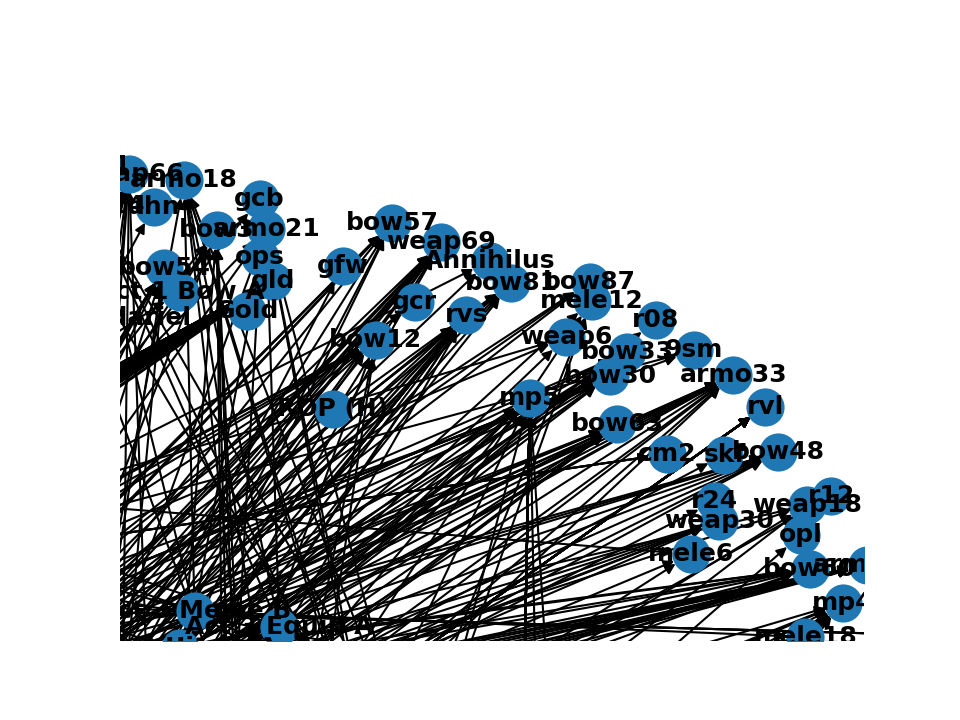

In [35]:
#G = nx.petersen_graph()
plt.subplot(111)

nx.draw(g, with_labels=True, font_weight='bold')
#nx.draw_networkx_edge_labels(g)
#plt.subplot(122)

#nx.draw_shell(g, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [142]:
print(not not '')

False


In [96]:
list(predecessor_iter(g2, 'axe'))

['axe', 'taxe']